In [1]:
# GenAI has been used and marked with inline comments

import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

random.seed(42)

# Occupancy Map

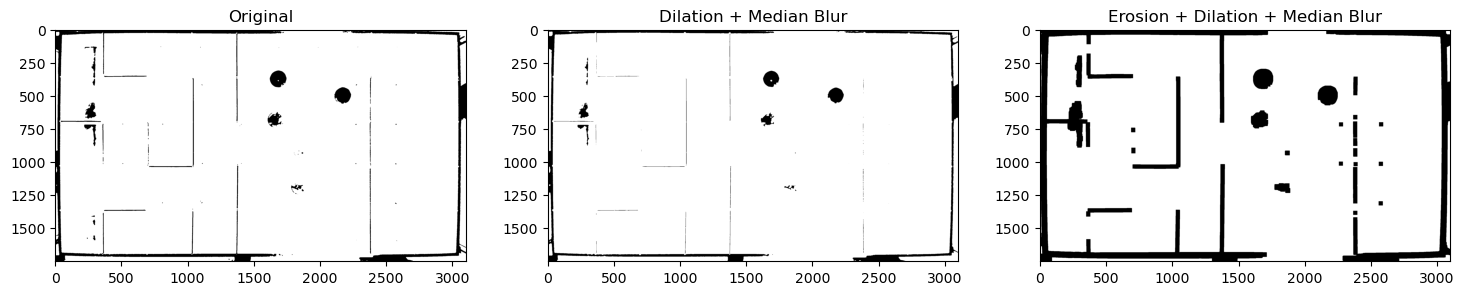

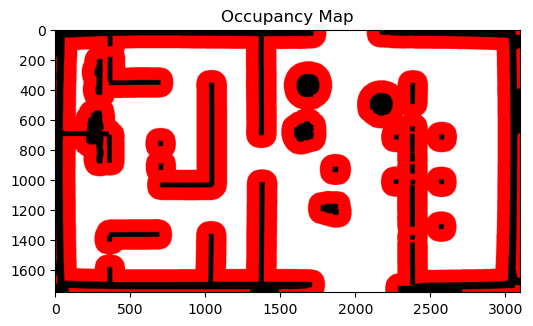

In [12]:
IMAGE_FILE = "maze_continue.jpg"
image = cv2.imread(IMAGE_FILE,cv2.IMREAD_GRAYSCALE)
img = image[250:2000, 400:3500] # Crop image

(_, img) = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
img = cv2.medianBlur(img, 7)

kernelDilation = np.ones((3,3), np.uint8)
dilate1 = cv2.dilate(img, kernelDilation, iterations = 2)

# CROP SHADOWS FROM COMMON PROBLEM AREAS (CORNERS OF MAZE)
dilate1[1400:1600,150:450] = 255
dilate1[1400:1650,2750:2900] = 255
dilate1[100:200,150:450] = 255
dilate1[100:200,2750:2900] = 255

kernelErosion = np.ones((7,7), np.uint8)
erosion1 = cv2.erode(dilate1, kernelErosion, iterations = 5)


# Plot for visualisation
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 10), ncols = 3)
ax1.imshow(img, cmap='gray'), ax1.set_title("Original")
ax2.imshow(dilate1, cmap='gray'), ax2.set_title("Dilation + Median Blur")
ax3.imshow(erosion1, cmap='gray'), ax3.set_title("Erosion + Dilation + Median Blur")
plt.show()

kernel = np.ones((30, 30), np.uint8) # Use this kernel to generate un_safe area

kernel_size = 35
circular_kernel = np.zeros((kernel_size, kernel_size), np.uint8)
center = kernel_size // 2
radius = kernel_size // 2
for i in range(kernel_size):
    for j in range(kernel_size):
        if (i - center)**2 + (j - center)**2 <= radius**2:
            circular_kernel[i, j] = 1
        else:
            circular_kernel[i, j] = 0

# Find the unsafe area around objects
unsafeArea = cv2.erode(erosion1, circular_kernel, iterations=5)

# Highlight unsafe areas in red on original image 
mask = unsafeArea < erosion1
img_RGB = cv2.cvtColor(erosion1, cv2.COLOR_GRAY2RGB)
img_RGB[mask] = [255, 0, 0]

# Display resulting image
fig, ax1 = plt.subplots(figsize = (6, 4), ncols = 1)
ax1.imshow(img_RGB, cmap='gray'), ax1.set_title("Occupancy Map")
plt.show()

# NOTE: OCCUPANCY_MAP is an RGB Image. 
# NOTE: Please call it as "OCCUPANCY_MAP.copy()" to not damage the original map for later code usage
OCCUPANCY_MAP_BW = img_RGB.copy()

HSV MASKING OCCUPANCY MAP!!

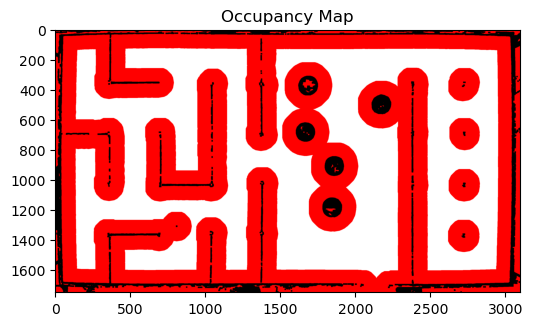

In [13]:
image = cv2.imread(IMAGE_FILE)

# Crop the image to the specified size
cropped_image = image[250:2000, 400:3500]

# Convert the cropped image to HSV color space
hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

# Define the HSV range for masking the maze walls
# The actual range might need adjustment based on the image
lower_bound = np.array([50, 0, 51])
upper_bound = np.array([200, 70, 115])

# Create a mask for the maze walls based on the HSV range
mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
mask = cv2.medianBlur(mask, 3)

# Perform morphological operations to clean up the mask
# Erosion followed by dilation to remove noise and small artifacts

kernel = np.ones((5, 5), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=2)

# The walls are already black in the mask, so no need to invert
result = result = cv2.bitwise_not(mask)

kernel_size = 42
circular_kernel = np.zeros((kernel_size, kernel_size), np.uint8)
center = kernel_size // 2
radius = kernel_size // 2
for i in range(kernel_size):
    for j in range(kernel_size):
        if (i - center)**2 + (j - center)**2 <= radius**2:
            circular_kernel[i, j] = 1
        else:
            circular_kernel[i, j] = 0

# Find the unsafe area around objects
unsafeArea = cv2.erode(result, circular_kernel, iterations=5)

# Highlight unsafe areas in red on original image 
mask = unsafeArea < result
img_RGB = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
img_RGB[mask] = [255, 0, 0]

fig, ax1 = plt.subplots(figsize = (6, 4), ncols = 1)
ax1.imshow(img_RGB, cmap='gray'), ax1.set_title("Occupancy Map")
plt.show()

OCCUPANCY_MAP = img_RGB.copy()

NOTE: OCCUPANCY_MAP is an RGB Image. 

NOTE: Please instantiate it as "OCCUPANCY_MAP.copy()" to not damage the original map for later code usage

# Path Planning - BFS


In [4]:
## Graph Class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = {}
        pass

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 not in self.nodes or node_id2 not in self.nodes:
            pass
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight
        pass

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
            del self.edges[node_id2][node_id1]
        pass
    
    def get_nodes(self):
        return list(self.nodes.values())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2] 
        else:
            return None

In [5]:
## Path Clear Function - Identifies if the path between nodes is free of walls

def path_clear(image, x1, y1, x2, y2):
    # Vertically connected nodes
    if x1 == x2:
        y_start = min(y1,y2)
        y_end = max(y1,y2)
        while y_start != y_end:
            if image[y_start,x1][0] != 255 or image[y_start,x1][1] != 255 or image[y_start,x1][2] != 255:
                return False
            y_start += 1
            
    # Horizontally connected nodes        
    elif y1 == y2:
        x_start = min(x1,x2)
        x_end = max(x1,x2)
        while x_start != x_end:
            if image[y1,x_start][0] != 255 or image[y1,x_start][1] != 255 or image[y1,x_start][2] != 255:
                return False
            x_start += 1
            
    # Check diagonal line
    if (x1 != x2 and y1 != y2):
        if (x1 > x2):
            x1, x2 = x2, x1
            y1, y2 = y2 ,y1
        for x in range(x1, x2 + 1):  
            y = round(y1 + (x - x1) * (y2 - y1) / (x2 - x1))
            if np.all(image[y][x] == [0, 0, 0]) or np.all(image[y][x] == [255, 0, 0]):
                return False
        if (y1 > y2):
            x1, x2 = x2, x1
            y1, y2 = y2 ,y1
        for y in range(y1, y2 + 1):  
            x = round(x1 + (y - y1) * (x2 - x1) / (y2 - y1))
            if np.all(image[y][x] == [0, 0, 0]) or np.all(image[y][x] == [255, 0, 0]):
                return False
            
    return True

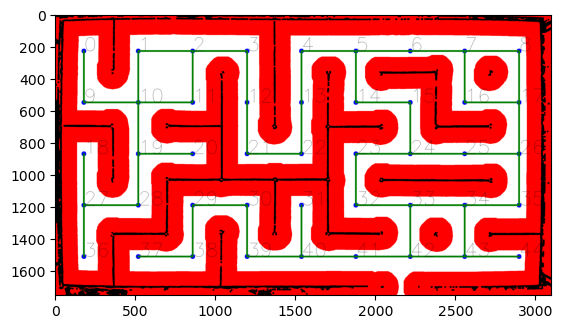

In [6]:
## Map of nodes and edges

size_of_node_grid_x = 9
size_of_node_grid_y = 5

bfs_image = OCCUPANCY_MAP.copy()
bfs_graph = Graph()

height, width, channels = bfs_image.shape
# start_y = round(height / (size_of_node_grid_y + 1))
# start_x = round(width / (size_of_node_grid_x + 1))
start_y = 230
start_x = 180

dy = 320
dx = 340

# Make all the nodes
row = 0
while row < size_of_node_grid_y:
    col = 0
    while col < size_of_node_grid_x:
        bfs_graph.add_node((row * size_of_node_grid_x + col), start_x + (dx * col), start_y + (dy * row))
        col = col + 1
    row = row + 1

# Make edges between nodes
maxnode = size_of_node_grid_x * size_of_node_grid_y - 1
i = 0
while i <= maxnode:
    top_of_node = i-size_of_node_grid_x
    left_of_node = i-1
    right_of_node = i+1
    bot_of_node = i+size_of_node_grid_x
    
    bfs_graph.add_edge(i, top_of_node, 1)
    bfs_graph.add_edge(i, bot_of_node, 1)
    if i % size_of_node_grid_x != size_of_node_grid_x - 1:
        bfs_graph.add_edge(i, right_of_node, 1)
    if i % size_of_node_grid_x != 0:
        bfs_graph.add_edge(i, left_of_node, 1)
    i = i + 1

# Identify when obstacle is between edge and remove them if they are
for node in bfs_graph.get_nodes():
    edge_removal = [];
    node_x, node_y = bfs_graph.nodes[node.get_ID()].get_point()
    for connected_node, weight in bfs_graph.edges[node.get_ID()].items():
        connected_x, connected_y = bfs_graph.nodes[connected_node].get_point()  
        if path_clear(bfs_image, node_x, node_y, connected_x, connected_y) == False:
            edge_removal.append(connected_node)    
    for delink_node in edge_removal:
        bfs_graph.remove_edge(node.get_ID(), delink_node)

    
# Draw a circle at each node and line at each edge:
for node in bfs_graph.get_nodes():
    node_x, node_y = bfs_graph.nodes[node.get_ID()].get_point()
    cv2.circle(bfs_image, (node_x,node_y), 15, (0,0,255), -1)
    for connected_node, weight in bfs_graph.edges[node.get_ID()].items():
        connected_x, connected_y = bfs_graph.nodes[connected_node].get_point()
        cv2.line(bfs_image, (node_x,node_y), (connected_x, connected_y), (0,125,0), 10)

# Indicate all nodes
for node in bfs_graph.get_nodes():
    node_x, node_y = bfs_graph.nodes[node.get_ID()].get_point()
    node_ID = node.get_ID()
    font = cv2.FONT_HERSHEY_SIMPLEX
    node_ID = str(node_ID)
    cv2.putText(bfs_image, node_ID, (node_x, node_y), font, 4, (0,0,0),1,cv2.LINE_AA)        

    
plt.imshow(bfs_image)
plt.show()

In [7]:
# Match each node with corresponding RW ID
def getRealCoords(graph):
    idCoordDict = {}
    i = 0; j = 0;

    for node in graph.get_nodes():
        if i > 8:
            i = 0
            j = j + 1
        xOfst = 250; yOfst = 250;
        idCoordDict[node.get_ID()] = (125+(i*xOfst), 125+(j*yOfst))
        i = i+1

    realWorldCoords = list(idCoordDict.values())
    return realWorldCoords


print(getRealCoords(bfs_graph)) # realWorldCoords is a list of tuples of (x_i, y_i)


[(125, 125), (375, 125), (625, 125), (875, 125), (1125, 125), (1375, 125), (1625, 125), (1875, 125), (2125, 125), (125, 375), (375, 375), (625, 375), (875, 375), (1125, 375), (1375, 375), (1625, 375), (1875, 375), (2125, 375), (125, 625), (375, 625), (625, 625), (875, 625), (1125, 625), (1375, 625), (1625, 625), (1875, 625), (2125, 625), (125, 875), (375, 875), (625, 875), (875, 875), (1125, 875), (1375, 875), (1625, 875), (1875, 875), (2125, 875), (125, 1125), (375, 1125), (625, 1125), (875, 1125), (1125, 1125), (1375, 1125), (1625, 1125), (1875, 1125), (2125, 1125)]


In [8]:
## BFS algorithm - Returns an array of nodes, starting from the startID to endID
def bfs(graph, start_node_id, end_node_id):
    Q = []
    Visited = []
    path = []
    
    parent_pointers = []
    index_pos = 0
    for node in graph.get_nodes():
        if node.get_ID() == start_node_id:
            parent_pointers.append((node.get_ID(), index_pos, -1))
        else:
            parent_pointers.append((node.get_ID(), index_pos, -2))
        index_pos = index_pos + 1
    
    Q.append(start_node_id)
    Visited.append(start_node_id)
    while Q:
        x = Q[0]
        if x == end_node_id:
            counter = 0
            for node in parent_pointers:
                if node[0] == end_node_id:
                    counter = node[2]
                    path.append(node[0])
            while counter != -1:
                for node in parent_pointers:
                    if node[0] == counter:
                        path.append(node[0])
                        counter = node[2]
            path.reverse()
            return path
        for node in graph.edges[x]:
            if node not in Visited:
                Visited.append(node)
                Q.append(node)
                parent_pointers = update_parent_pointer(node, x, parent_pointers)
        Q.pop(0)
            
            
def update_parent_pointer(child_id, parent_id, parent_pointers):
    for node in parent_pointers:
        if node[0] == parent_id:
            parent_index = node[1]
    for node in parent_pointers:
        if node[0] == child_id:
            parent_pointers[node[1]] = (node[0], node[1], parent_index)
    return parent_pointers


In [9]:
def find_direction_to_face(current_node, next_node, facing_direction):
    
    start_x, start_y = bfs_graph.nodes[current_node].get_point()
    end_x, end_y = bfs_graph.nodes[next_node].get_point()
    if start_x == end_x:
        if start_y < end_y:
            return "S"
        else:
            return "N"
    else:
        if start_x > end_x:
            return "W"
        else:
            return "E"

In [10]:
def turn_robot(robotDirections, facing_direction, direction_to_face, directions):
    # Identify the amount of turns the robot needs to make and minimise the amount of turns it should take
    
    ###################### Sectioned code is taken from GenAI ###############################
    current_idx = directions.index(facing_direction)
    target_idx = directions.index(direction_to_face)
    right_turns = (target_idx - current_idx) % 4
    left_turns = (current_idx - target_idx) % 4
    #########################################################################################
    
    i = 0
    if right_turns <= left_turns:
        while i < right_turns:
            robotDirections.append("r")
            i += 1
    else:
        robotDirections.append("l")
        
    facing_direction = direction_to_face
    return robotDirections, facing_direction

Path: rrfrflfffrffrfflflffrfrflfrfrflflfrfrfffrflflfrf
125,1125,125,875,375,875,375,125,875,125,875,625,1125,625,1125,125,1375,125,1375,375,1625,375,1625,625,1375,625,1375,875,1625,875,1625,1125,875,1125,875,875,625,875,625,1125,375,1125


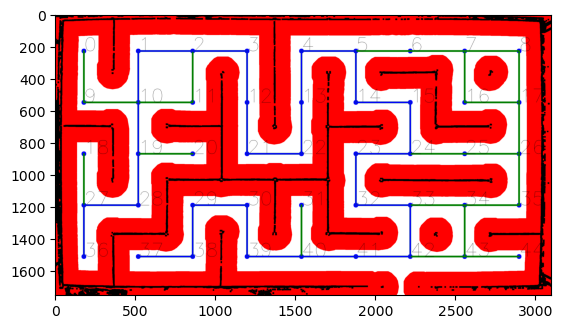

In [11]:
## Run BFS

# Variables to change per run:
directions = ["N", "E", "S", "W"]
bfs_start_node = 36
bfs_end_node = 37
facing_direction = directions[2]

path = bfs(bfs_graph,bfs_start_node,bfs_end_node)
robotDirections = []

for index, value in enumerate(path):
    # Reached the end
    if index == len(path) - 1:
        break
        
    # Find direction to face
    next_value = path[index + 1]
    direction_to_face = find_direction_to_face(value, next_value, facing_direction)
    
    # Turn if the robot needs to
    if facing_direction != direction_to_face:
        robotDirections, facing_direction = turn_robot(robotDirections, facing_direction, direction_to_face, directions)
        
    # Go forward
    robotDirections.append("f")

robotDirections = ''.join(robotDirections)
print(f"Path: {robotDirections}")
realWorldCoords = getRealCoords(bfs_graph)



coords1 = []
for node in path:
    coords1.append(realWorldCoords[node])

flat_list = [item for tup in coords1 for item in tup]

filtered_coords = [coords1[0]]

for i in range(1, len(coords1) - 1):
    prev_x, prev_y = coords1[i - 1]
    curr_x, curr_y = coords1[i]
    next_x, next_y = coords1[i + 1]
    
    # If current point does not form a straight line with previous and next, keep it
    if not ((prev_x == curr_x == next_x) or (prev_y == curr_y == next_y)):
        filtered_coords.append(coords1[i])

# Add the last coordinate
filtered_coords.append(coords1[-1])

flat_list = [item for tup in filtered_coords for item in tup]
print(','.join(map(str, flat_list)))

bfs_whole = bfs_image.copy()

# Draw the path
for i in range(len(path) - 1):
    current_coord = bfs_graph.nodes[path[i]].get_point()
    next_coord = bfs_graph.nodes[path[i + 1]].get_point()
    cv2.line(bfs_whole, current_coord, next_coord, (0, 0, 255), 8)

plt.imshow(bfs_whole)
plt.show()

# Continuous Planning - RRT* + BFS

BFS For first and second halves

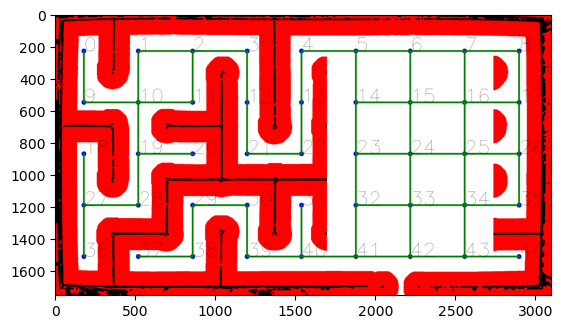

In [18]:
## Identify the start and end of the obstacle course 

bfs_check = OCCUPANCY_MAP.copy()
bfs_graph_check = Graph()

height, width, channels = bfs_image.shape
start_y = 230
start_x = 180
dy = 320
dx = 340

########################## HARD CODE THESE POSITIONS
obstacle_start_col = 8
obstacle_end_col = 6

# range_start = (obstacle_start_col-1) * 370
# range_end = (obstacle_end_col-1) * 370
if obstacle_start_col < obstacle_end_col:
    range_start = dx*(obstacle_start_col-1)
    range_end = dx*(obstacle_end_col-1) + start_x*2
else:
    range_start = dx*(obstacle_end_col-1)
    range_end = dx*(obstacle_start_col-1) + start_x*2

bfs_check[150:1550,range_start:range_end] = 255

# bfs_check[150:1550,1800:2660] = 255

realWorldCoords = getRealCoords(bfs_graph)


# Make all the nodes
row = 0
while row < size_of_node_grid_y:
    col = 0
    while col < size_of_node_grid_x:
        bfs_graph_check.add_node((row * size_of_node_grid_x + col), start_x + (dx * col), start_y + (dy * row))
        col = col + 1
    row = row + 1

# Make edges between nodes
maxnode = size_of_node_grid_x * size_of_node_grid_y - 1
i = 0
while i <= maxnode:
    top_of_node = i-size_of_node_grid_x
    left_of_node = i-1
    right_of_node = i+1
    bot_of_node = i+size_of_node_grid_x
    
    bfs_graph_check.add_edge(i, top_of_node, 1)
    bfs_graph_check.add_edge(i, bot_of_node, 1)
    if i % size_of_node_grid_x != size_of_node_grid_x - 1:
        bfs_graph_check.add_edge(i, right_of_node, 1)
    if i % size_of_node_grid_x != 0:
        bfs_graph_check.add_edge(i, left_of_node, 1)
    i = i + 1

# Identify when obstacle is between edge and remove them if they are
for node in bfs_graph_check.get_nodes():
    edge_removal = [];
    node_x, node_y = bfs_graph_check.nodes[node.get_ID()].get_point()
    for connected_node, weight in bfs_graph_check.edges[node.get_ID()].items():
        connected_x, connected_y = bfs_graph_check.nodes[connected_node].get_point()  
        if path_clear(bfs_check, node_x, node_y, connected_x, connected_y) == False:
            edge_removal.append(connected_node)    
    for delink_node in edge_removal:
        bfs_graph_check.remove_edge(node.get_ID(), delink_node)

    
# Draw a circle at each node and line at each edge:
for node in bfs_graph_check.get_nodes():
    node_x, node_y = bfs_graph_check.nodes[node.get_ID()].get_point()
    cv2.circle(bfs_check, (node_x,node_y), 15, (0,0,255), -1)
    for connected_node, weight in bfs_graph_check.edges[node.get_ID()].items():
        connected_x, connected_y = bfs_graph_check.nodes[connected_node].get_point()
        cv2.line(bfs_check, (node_x,node_y), (connected_x, connected_y), (0,125,0), 10)

# Indicate all nodes
for node in bfs_graph_check.get_nodes():
    node_x, node_y = bfs_graph_check.nodes[node.get_ID()].get_point()
    node_ID = node.get_ID()
    font = cv2.FONT_HERSHEY_SIMPLEX
    node_ID = str(node_ID)
    cv2.putText(bfs_check, node_ID, (node_x, node_y), font, 4, (0,0,0),1,cv2.LINE_AA)        

plt.imshow(bfs_check)
plt.show()

list_of_starts = []
start_connected = []
for i in range(0, 5):
    list_of_starts.append(obstacle_start_col-1+9*i)

for value in list_of_starts:
    for node in bfs_graph_check.get_nodes():
        node_ID = node.get_ID()
        if node_ID == value:
            start_connected.append(len(bfs_graph_check.edges[node_ID].items()))
            
for index, value in enumerate(start_connected):
    if index == 0:
        if value == 3:
            row_pos = index
    if value == 4:
        row_pos = index
    if index == len(start_connected) - 1:
        if value == 3:
            row_pos = index
            
for index, value in enumerate(list_of_starts):
    if index == row_pos:
        rrt_start_node = value
        
if obstacle_start_col < obstacle_end_col:
    rrt_start_node = rrt_start_node - 1
else:
    rrt_start_node = rrt_start_node + 1

list_of_ends = []
end_connected = []
for i in range(0, 5):
    list_of_ends.append(obstacle_end_col-1+9*i)

for value in list_of_ends:
    for node in bfs_graph_check.get_nodes():
        node_ID = node.get_ID()
        if node_ID == value:
            end_connected.append(len(bfs_graph_check.edges[node_ID].items()))
            
for index, value in enumerate(end_connected):
    if index == 0:
        if value == 3:
            row_pos = index
    if value == 4:
        row_pos = index
    if index == len(end_connected) - 1:
        if value == 3:
            row_pos = index
            
for index, value in enumerate(list_of_ends):
    if index == row_pos:
        rrt_end_node = value
        
if obstacle_start_col < obstacle_end_col:
    rrt_end_node = rrt_end_node + 1
else:
    rrt_end_node = rrt_end_node - 1



Path: rrff
2125,125,2125,625


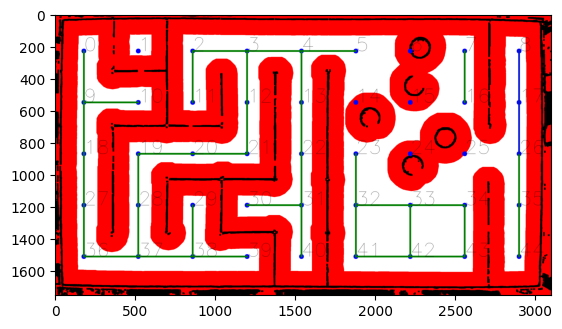

In [23]:
## Run BFS for first half

bfs_first = bfs_image.copy()

# Variables to change per run:
directions = ["N", "E", "S", "W"]
bfs_start_node = 8
bfs_end_node = rrt_start_node
facing_direction = directions[0]

path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

robotDirections = []

for index, value in enumerate(path):
    # Reached the end
    if index == len(path) - 1:
        break
        
    # Find direction to face
    next_value = path[index + 1]
    direction_to_face = find_direction_to_face(value, next_value, facing_direction)
    
    # Turn if the robot needs to
    if facing_direction != direction_to_face:
        robotDirections, facing_direction = turn_robot(robotDirections, facing_direction, direction_to_face, directions)
        
    # Go forward
    robotDirections.append("f")

robotDirections = ''.join(robotDirections)
print(f"Path: {robotDirections}")

# Match each node with corresponding RW ID
realWorldCoords = getRealCoords(bfs_graph)

coords1 = []
for node in path:
    coords1.append(realWorldCoords[node])

flat_list = [item for tup in coords1 for item in tup]

filtered_coords = [coords1[0]]

for i in range(1, len(coords1) - 1):
    prev_x, prev_y = coords1[i - 1]
    curr_x, curr_y = coords1[i]
    next_x, next_y = coords1[i + 1]
    
    # If current point does not form a straight line with previous and next, keep it
    if not ((prev_x == curr_x == next_x) or (prev_y == curr_y == next_y)):
        filtered_coords.append(coords1[i])

# Add the last coordinate
filtered_coords.append(coords1[-1])

flat_list = [item for tup in filtered_coords for item in tup]
print(','.join(map(str, flat_list)))

# Draw the path
for i in range(len(path) - 1):
    current_coord = bfs_graph.nodes[path[i]].get_point()
    next_coord = bfs_graph.nodes[path[i + 1]].get_point()
    cv2.line(bfs_first, current_coord, next_coord, (0, 0, 255), 8)

plt.imshow(bfs_first)
plt.show()



Path: lflffrfflffrfrffff
1125,125,875,125,875,625,375,625,375,1125,125,1125,125,125


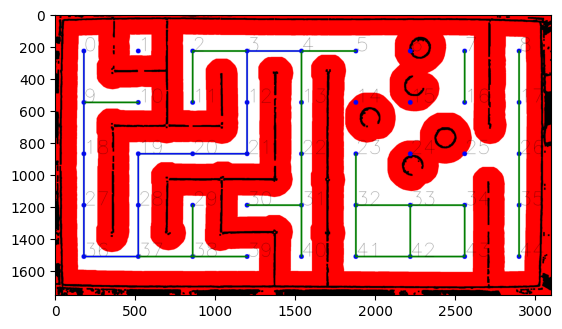

In [24]:
## Run BFS

bfs_second = bfs_image.copy()

# Variables to change per run:
directions = ["N", "E", "S", "W"]
bfs_start_node = rrt_end_node
bfs_end_node = 0
facing_direction = directions[0]

path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

robotDirections = []

for index, value in enumerate(path):
    # Reached the end
    if index == len(path) - 1:
        break
        
    # Find direction to face
    next_value = path[index + 1]
    direction_to_face = find_direction_to_face(value, next_value, facing_direction)
    
    # Turn if the robot needs to
    if facing_direction != direction_to_face:
        robotDirections, facing_direction = turn_robot(robotDirections, facing_direction, direction_to_face, directions)
        
    # Go forward
    robotDirections.append("f")

robotDirections = ''.join(robotDirections)
print(f"Path: {robotDirections}")

realWorldCoords = getRealCoords(bfs_graph)

coords1 = []
for node in path:
    coords1.append(realWorldCoords[node])

flat_list = [item for tup in coords1 for item in tup]

filtered_coords = [coords1[0]]

for i in range(1, len(coords1) - 1):
    prev_x, prev_y = coords1[i - 1]
    curr_x, curr_y = coords1[i]
    next_x, next_y = coords1[i + 1]
    
    # If current point does not form a straight line with previous and next, keep it
    if not ((prev_x == curr_x == next_x) or (prev_y == curr_y == next_y)):
        filtered_coords.append(coords1[i])

# Add the last coordinate
filtered_coords.append(coords1[-1])

flat_list = [item for tup in filtered_coords for item in tup]
print(','.join(map(str, flat_list)))

# Draw the path
for i in range(len(path) - 1):
    current_coord = bfs_graph.nodes[path[i]].get_point()
    next_coord = bfs_graph.nodes[path[i + 1]].get_point()
    cv2.line(bfs_second, current_coord, next_coord, (0, 0, 255), 8)

plt.imshow(bfs_second)
plt.show()

# Add path to final image
for i in range(len(path) - 1):
    current_coord = bfs_graph.nodes[path[i]].get_point()
    next_coord = bfs_graph.nodes[path[i + 1]].get_point()
    cv2.line(bfs_first, current_coord, next_coord, (0, 0, 255), 8)



RRT that I don't understand

In [25]:
# Constant variables

iterations = 1000
k_connections = 3
max_connection_range = 100
start_location = bfs_graph.nodes[rrt_start_node].get_point()
goal_location = bfs_graph.nodes[rrt_end_node].get_point()

goal_radius = 20
step = 90

In [26]:
# Implement tree class
class Tree():
    def __init__(self):
        self.parent = {}  # {child: (parent, weight)}
        
    def add_branch(self, parent_id, child_id, weight):
        self.parent.update({child_id: (parent_id, weight)})
        
    def remove_branch(self, parent_id, child_id):
        if (child_id in self.parent):
            self.parent.pop(child_id)
            
    def get_path(self, start_id, goal_id):
        path = []
        current_node = goal_id
        while (current_node != start_id):
            path.insert(0, current_node)
            current_node = self.parent[current_node][0]
        path.insert(0, start_id)
        return path
    
    def get_cost(self, start_id, goal_id):
        cost = 0
        current_node = goal_id
        while (current_node != start_id):
            cost += self.parent[current_node][1]
            current_node = self.parent[current_node][0]
        return cost

In [27]:
# This is a useful function which you may choose to impliment and use 
# It finds and returns the n closest nodes which are within the range
def find_closest_nodes(image, graph, target_x, target_y, n, connection_range):

    distances = []
    
    # Find nodes within the range
    for node in graph.get_nodes():
        node_id = node.get_ID()
        coord = node.get_point()
        distance = math.sqrt((coord[0] - target_x)**2 + (coord[1] - target_y)**2)
        if (distance <= connection_range and distance != 0 and path_clear(image, target_x, target_y, coord[0], coord[1])):
            distances.append((node_id, distance))
    
    if (len(distances) == 0 or len(distances) == 1):
        return distances
    
    # Bubble sort distances list
    for i in range(len(distances) - 1):
        for j in range(len(distances) - i - 1):
            if (distances[j][1] > distances[j + 1][1]):
                distances[j], distances[j + 1] = distances[j + 1], distances[j]
    
    return distances[:n]  # list of (node_id, distance)

# This is a useful function which you may choose to impliment and use 
# Given a random point it extends the tree by either the step distance or the cartesian distance
def calculate_new_tree_point(x_closest, y_closest, x, y, step):

    distance = math.sqrt((x - x_closest)**2 + (y - y_closest)**2)
    
    if (distance <= step): 
        return x, y, distance
    else:
        vector = (x - x_closest, y - y_closest)
        alpha = step / distance
        scaled_vec = (alpha * vector[0], alpha * vector[1])
    
        x_new = round(x_closest + scaled_vec[0])
        y_new = round(y_closest + scaled_vec[1])
        return x_new, y_new, step
    

# This is a useful function which you may choose to impliment and use 
# It finds and returns the closest node to a point on the image
def find_closest_node_rrt(graph, target_x, target_y):

    closest_node_id = -1
    first_node_coord = graph.nodes[closest_node_id].get_point()
    closest_node_distance = math.sqrt((first_node_coord[0] - target_x)**2 + (first_node_coord[1] - target_y)**2)
    
    # Find nodes with minimum distance
    for node in graph.get_nodes():
        node_id = node.get_ID()
        coord = node.get_point()
        distance = math.sqrt((coord[0] - target_x)**2 + (coord[1] - target_y)**2)
        if (distance < closest_node_distance):
            closest_node_distance = distance
            closest_node_id = node_id

    return closest_node_id

Running at iteration 0
Running at iteration 100
Goal reached at iteration 143
Running at iteration 200
Running at iteration 300
Running at iteration 400
Running at iteration 500
Running at iteration 600
Running at iteration 700
Running at iteration 800
Running at iteration 900
Path: [-1, 849, 876, 2, 3, 652, 65, 910, 274, 835, 10, 304, 834, 177, 555, 766, 495, 62, 902, 86, 90, 96, 104, 123, 126, 132, 430, 195, 481, 140, 141, 898, -2], Cost: 2415.259333075527


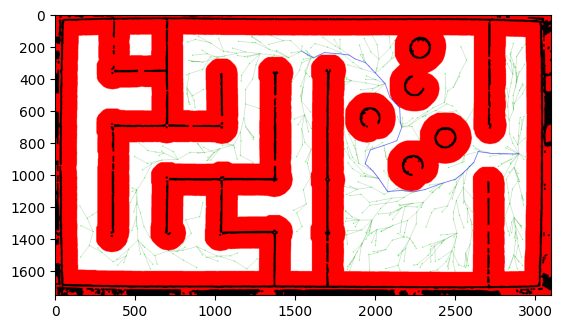

Coordinates:
2132,680,2091,680,2039,678,2010,679,1945,669,1924,722,1876,773,1840,803,1786,821,1761,830,1700,854,1646,865,1596,858,1528,863,1488,800,1461,764,1425,728,1449,661,1511,639,1571,616,1593,550,1587,527,1584,456,1539,405,1517,338,1472,287,1427,237,1378,218,1351,199,1304,193,1238,188,1188,213,1132,180

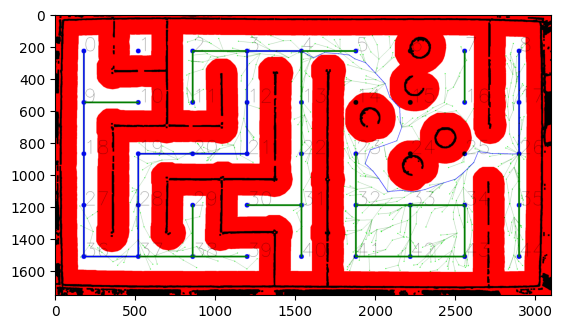

In [28]:
# Task 5.1 (3 marks): RRT/RRT*
# Use the same start and goal locations as PRM 

# NOTE: for this implimentation the next iteration is reach only if a valid node is placed
# If, from the source location there is no valid path to the newly placed node. Then the iteration is repeated and a new random x,y location are selected 

rrt_image = OCCUPANCY_MAP.copy()
rrt_graph = Graph()
rrt_tree = Tree()
# random.seed(seed)

# Generate the start node with a node_ID of -1
rrt_graph.add_node(-1, start_location[0], start_location[1])
cv2.circle(rrt_image, start_location, 3, (0, 255, 0), -1)

# RRT* algorithm
goal_reach = False
beta = 0.2
i = 0
while i < iterations:
    
    if (random.random() < beta):
        # Choose goal as target node
        x = goal_location[0]
        y = goal_location[1]
    else:
        # Randomly choose a target node
        y = random.randint(0, rrt_image.shape[0]-1)  # row -> y
        x = random.randint(0, rrt_image.shape[1]-1)  # col -> x
    
    # Check if the current node is valid
    if (not path_clear(rrt_image, x, y, x, y)):
        continue
        
    # Find the closest node
    closest_node_id = find_closest_node_rrt(rrt_graph, x, y)

    # Find a new node between target and closest nodes
    closest_coord = rrt_graph.nodes[closest_node_id].get_point()
    x_new, y_new, distance_new = calculate_new_tree_point(closest_coord[0], closest_coord[1], x, y, step)

    # Check edge collision
    if (not path_clear(rrt_image, x_new, y_new, closest_coord[0], closest_coord[1])):
        continue
    
    ## RRT* Closest neighbour search
    # Find all nodes within the search range
    neighbour_search_range = 100
    neighbour_nodes = find_closest_nodes(rrt_image, rrt_graph, x_new, y_new, neighbour_search_range, neighbour_search_range)  # [(id, weight)]
    
    # Find node with the lowest cost from start
    best_id = neighbour_nodes[0][0]
    best_weight = neighbour_nodes[0][1]
    min_cost = rrt_tree.get_cost(-1, best_id) + best_weight
    for node in neighbour_nodes:
        current_id = node[0]
        current_weight = node[1]
        current_cost = rrt_tree.get_cost(-1, current_id) + current_weight
        if (current_cost < min_cost):
            min_cost = current_cost
            best_id = current_id     
            best_weight = current_weight  
    ##
                       
    # Add best node and edge to graph
    rrt_graph.add_node(i, x_new, y_new)
    rrt_graph.add_edge(best_id, i, best_weight)
      
    # Add best node to tree
    rrt_tree.add_branch(best_id, i, best_weight)
    
    ## RRT* Rewiring
    # Obtain the dictionary structure {neighbour_node_id: distance_from_new_node}
    neighbour_node_dict = {}  
    for node in neighbour_nodes:
        if (node[0] != best_id):
            neighbour_node_dict.update({node[0]: node[1]})
    # Compare distances between 'start->best->new->neighbour_nodes' and 'start->neighbour_nodes'
    for j in neighbour_node_dict.keys():
        distance_start_new_neighbour = rrt_tree.get_cost(-1, best_id) + best_weight + neighbour_node_dict[j]
        distance_start_neighbour = rrt_tree.get_cost(-1, j)
        if (distance_start_new_neighbour < distance_start_neighbour):
            # Rewiring to make sure every node within range has lowest cost from start
            neighbour_node_coord = rrt_graph.nodes[j].get_point()
            
            neighbour_parent_id = rrt_tree.parent[j][0]
            neighbour_parent_coord = rrt_graph.nodes[neighbour_parent_id].get_point()
            rrt_tree.remove_branch(neighbour_parent_id, j)
            rrt_graph.remove_edge(neighbour_parent_id, j)
            
            rrt_tree.add_branch(i, j, neighbour_node_dict[j])
            rrt_graph.add_edge(i, j, neighbour_node_dict[j])      
    ##

    # Check new node is within radius of the goal
    # If already reached goal, no need to check anymore
    if (goal_reach == False):
        distance_from_goal = math.sqrt((x_new - goal_location[0])**2 + (y_new - goal_location[1])**2)
        if (distance_from_goal <= goal_radius):
            goal_reach = True
            print("Goal reached at iteration", i)
            
            # Find closest node
            closest_node_id = find_closest_node_rrt(rrt_graph, goal_location[0], goal_location[1])
            closest_coord = rrt_graph.nodes[closest_node_id].get_point()
            weight = math.sqrt((closest_coord[0] - goal_location[0])**2 + (closest_coord[1] - goal_location[1])**2)
            
            # Add goal node
            rrt_graph.add_node(-2, goal_location[0], goal_location[1])
            cv2.circle(rrt_image, goal_location, 3, (0, 255, 0), -1)
            
            # Connect goal to closest node
            rrt_graph.add_edge(-2, closest_node_id, weight)
            cv2.line(rrt_image, goal_location, closest_coord, (0, 125, 0), 1)

            # Add goal to tree
            rrt_tree.add_branch(closest_node_id, -2, weight)
    
    if (i % 100 == 0):
        print("Running at iteration", i)
    i += 1

# Draw all nodes and edges
for node in rrt_graph.get_nodes():
    node_id = node.get_ID()
    node_coord = node.get_point()
    
    cv2.circle(rrt_image, node_coord, 3, (0, 255, 0), -1)
    
    for connected_node_id in rrt_graph.edges[node_id].keys():
        connected_coord = rrt_graph.nodes[connected_node_id].get_point()
        cv2.line(rrt_image, node_coord, connected_coord, (0, 125, 0), 1)

# Use tree to find path and cost
path = rrt_tree.get_path(-1, -2)
cost = rrt_tree.get_cost(-1, -2)
   
# Draw the path
for i in range(len(path) - 1):
    current_coord = rrt_graph.nodes[path[i]].get_point()
    next_coord = rrt_graph.nodes[path[i + 1]].get_point()
    cv2.line(rrt_image, current_coord, next_coord, (0, 0, 255), 2)

# Display resulting image
print(f"Path: {path}, Cost: {cost}")
plt.imshow(rrt_image)
plt.show()

# Print out the coordinates of the path
print("Coordinates:\n", end="")
for node_id in path:
    coord = rrt_graph.nodes[node_id].get_point();
    coord_x = round(coord[0]/(dx*9)*2250)
    coord_y = round(coord[1]/(dy*5)*1250)
    print(f"{coord_x},{coord_y}", end="")
    if (node_id != -2):
        print(",", end="")

complete_img = cv2.bitwise_and(bfs_first, rrt_image)
plt.imshow(complete_img)
plt.show()